In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # Change VGG16 to ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
    print(root, folders)

/kaggle/input ['mp-2-resize']
/kaggle/input/mp-2-resize ['CleanDataset']
/kaggle/input/mp-2-resize/CleanDataset ['Resized_Images']
/kaggle/input/mp-2-resize/CleanDataset/Resized_Images []


In [3]:
df = pd.read_csv('/kaggle/input/mp-2-resize/CleanDataset/clean_and_merged_df.csv')

# Define the image directory
image_dir = '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images'


In [4]:
# Append the full path to imageid column
df['imageid'] = df['imageid'].apply(lambda x: os.path.join(image_dir, x))

In [5]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['glaucoma'], random_state=42)

In [6]:
# Rename 'glaucoma' column to 'target' in both dataframes
train_df.rename(columns={'glaucoma': 'target'}, inplace=True)
val_df.rename(columns={'glaucoma': 'target'}, inplace=True)

# Update the labels to 'normal' for 0 and 'glaucoma' for 1
train_df['target'] = train_df['target'].replace({0: 'normal', 1: 'glaucoma'})
val_df['target'] = val_df['target'].replace({0: 'normal', 1: 'glaucoma'})

In [7]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define your target classes
class_mapping = {'normal': 0, 'glaucoma': 1}

# Create training and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='imageid',
    y_col='target',
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='imageid',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=list(class_mapping.keys())
)

Found 2056 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


In [8]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'normal': 0, 'glaucoma': 1}
{'normal': 0, 'glaucoma': 1}


In [9]:
# Function to print all information of a generator
def print_generator_info(generator, name='Generator'):
    print(f"\nInformation for {name}:")
    print(f"Class Indices: {generator.class_indices}")  # Class labels and their corresponding indices
    print(f"Classes: {generator.classes[:10]}")  # Display the first 10 class labels (encoded as integers)
    print(f"Batch Size: {generator.batch_size}")  # Batch size used in the generator
    print(f"Image Shape: {generator.image_shape}")  # Shape of the images fed into the model
    print(f"Total Samples: {generator.samples}")  # Total number of samples in the generator
    print(f"Steps Per Epoch: {generator.n}")  # Number of steps (batches) per epoch
    print(f"Target Size: {generator.target_size}")  # Target size of the images after resizing
    print(f"Color Mode: {generator.color_mode}")  # Color mode (e.g., 'rgb', 'grayscale')
    print(f"Shuffle: {generator.shuffle}")  # Whether the data is shuffled
    print(f"First 5 File Paths: {generator.filepaths[:5]}")  # First 5 file paths of the images

In [10]:
# Print information for both train_generator and val_generator
print_generator_info(train_generator, name='Train Generator')
print_generator_info(val_generator, name='Validation Generator')


Information for Train Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Batch Size: 32
Image Shape: (224, 224, 3)
Total Samples: 2056
Steps Per Epoch: 2056
Target Size: (224, 224)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2695.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1165.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_1034.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_953.jpg', '/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/n0096.jpg']

Information for Validation Generator:
Class Indices: {'normal': 0, 'glaucoma': 1}
Classes: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Batch Size: 32
Image Shape: (224, 224, 3)
Total Samples: 515
Steps Per Epoch: 515
Target Size: (224, 224)
Color Mode: rgb
Shuffle: True
First 5 File Paths: ['/kaggle/input/mp-2-resize/CleanDataset/Resized_Images/image_2035.jpg', '/kaggle/input/mp

In [11]:
# Print total number of images in train and validation generators
print(f"Total images in train_generator: {train_generator.samples}")
print(f"Total images in val_generator: {val_generator.samples}")

Total images in train_generator: 2056
Total images in val_generator: 515


In [12]:
# Step 1: Load the ResNet50 model with pre-trained ImageNet weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use ResNet50 instead of VGG16

# Step 2: Fine-tuning - Unfreeze some layers of the ResNet50 base model
# Unfreeze the last few convolutional blocks of the ResNet50 model
for layer in base_model.layers[:30]:  # Freeze the first 140 layers
    layer.trainable = False
for layer in base_model.layers[30:]:
    layer.trainable = True

# Define the model by adding custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with GlobalAveragePooling2D for ResNet
x = Dense(1, activation='sigmoid')(x)  # For binary classification

model = Model(inputs=base_model.input, outputs=x)

# Step 3: Recompile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,364,161 (89.13 MB)

 Non-trainable params: 225,600 (881.25 KB)

In [14]:
# [train the model]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [16]:
# Train the entire model again, with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=50,  # Fine-tune for more epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.7707 - loss: 0.5049 - val_accuracy: 0.6757 - val_loss: 0.6143 - learning_rate: 1.0000e-05
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - accuracy: 0.7762 - loss: 0.4878 - val_accuracy: 0.3417 - val_loss: 0.9035 - learning_rate: 1.0000e-05
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 354ms/step - accuracy: 0.7841 - loss: 0.4960 - val_accuracy: 0.6563 - val_loss: 0.6008 - learning_rate: 1.0000e-05
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 367ms/step - accuracy: 0.7874 - loss: 0.4891 - val_accuracy: 0.7437 - val_loss: 0.5026 - learning_rate: 1.0000e-05
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.7787 - loss: 0.4824 - val_accuracy: 0.7379 - val_loss: 0.4960 - learning_rate: 1.0000e-05
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - accuracy: 0.7725 - loss: 0.4895 - val_accuracy: 0.7689 - val_loss: 0.4697 - learning_rate: 1.0000e-05
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - acc

In [17]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss after fine-tuning: {loss}')
print(f'Validation Accuracy after fine-tuning: {accuracy}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8009 - loss: 0.4459
Validation Loss after fine-tuning: 0.45748716592788696
Validation Accuracy after fine-tuning: 0.784466028213501


In [18]:
# Get predictions for the validation set
y_pred_probs = model.predict(val_generator)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = val_generator.classes  # True classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Get predictions
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.round(y_pred_probs).astype(int)  # For binary classification

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Precision: 0.18
Recall: 0.08
F1 Score: 0.11


In [20]:
# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       392
           1       0.18      0.08      0.11       123

    accuracy                           0.69       515
   macro avg       0.47      0.48      0.46       515
weighted avg       0.62      0.69      0.65       515



In [21]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[346  46]
 [113  10]]


In [22]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_true_classes, y_pred_probs)  # y_pred_probs is already (n_samples,)
print(f'AUC-ROC: {auc_roc:.2f}')

AUC-ROC: 0.48


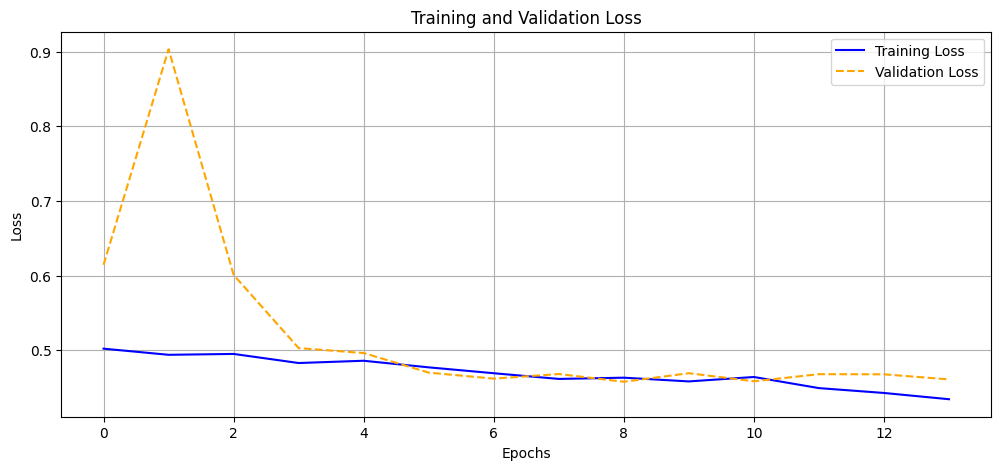

In [23]:
# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))

# Training Loss
plt.plot(history_finetune.history['loss'], label='Training Loss', color='blue', linestyle='-')
# Validation Loss
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

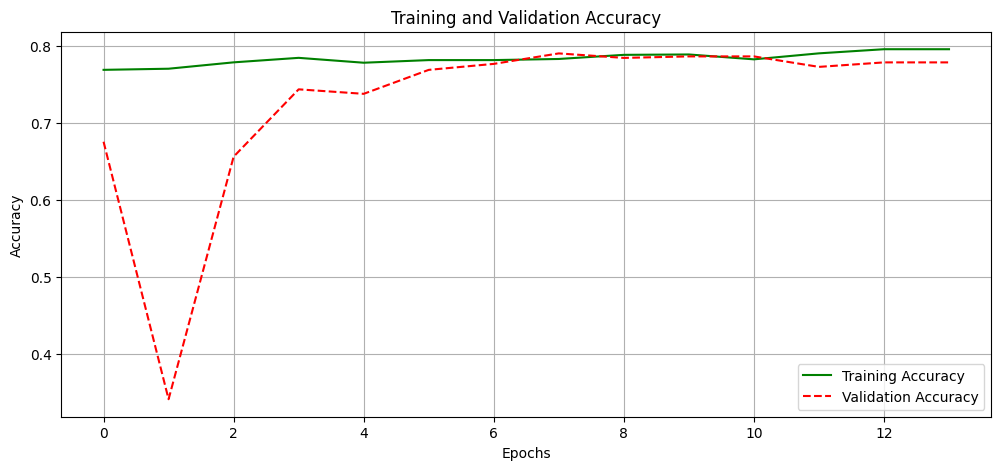

In [24]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training Accuracy
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
# Validation Accuracy
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model.save('/kaggle/working/MP_ResNet50-FineTuning.h5')